In [0]:
import numpy as np
from PIL import Image
import os
import glob
from skimage.io import imread,imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Data preprocessing

In [27]:
#load dataset images
orgs = glob.glob("in_final/img*.png")
print(orgs[:10])

masks_names = []
for i in range(len(orgs)):
    masks_names.append(orgs[i][len('in_final/img'):])
print(masks_names[:10])

masks = ['labels_1_final/' + masks_names[i] for i in range(len(masks_names))]  
print(masks[:10])

['in_final/img1_r12_c7.png', 'in_final/img2_r1_c6.png', 'in_final/img3_r1_c13.png', 'in_final/img7_r10_c9.png', 'in_final/img6_r2_c7.png', 'in_final/img3_r9_c1.png', 'in_final/img1_r2_c11.png', 'in_final/img9_r3_c12.png', 'in_final/img3_r7_c4.png', 'in_final/img7_r8_c5.png']
['1_r12_c7.png', '2_r1_c6.png', '3_r1_c13.png', '7_r10_c9.png', '6_r2_c7.png', '3_r9_c1.png', '1_r2_c11.png', '9_r3_c12.png', '3_r7_c4.png', '7_r8_c5.png']
['labels_1_final/1_r12_c7.png', 'labels_1_final/2_r1_c6.png', 'labels_1_final/3_r1_c13.png', 'labels_1_final/7_r10_c9.png', 'labels_1_final/6_r2_c7.png', 'labels_1_final/3_r9_c1.png', 'labels_1_final/1_r2_c11.png', 'labels_1_final/9_r3_c12.png', 'labels_1_final/3_r7_c4.png', 'labels_1_final/7_r8_c5.png']


### Binarization of labels:

In [0]:
# import function to binarize the label masks
from lib.utils import get_img_mask_array

In [0]:
img_list = []
mask_list = []
for path_in, path_label in zip(orgs, masks):
    img, mask = get_img_mask_array(path_in, 
                                   path_label,
                                   dim = 256,#define size to reshape the img
                                   n_channels = 1) #define number of channels ( 3 if use 'imagnet' weiths,                                                            # otherwise - 1 channel)
    img_list.append(img)
    mask_list.append(mask)
img_list = np.asarray(img_list)
mask_list = np.asarray(mask_list)

In [30]:
unique, counts = np.unique(mask_list, return_counts=True)
print('list of unique pixels: ', unique)
colormap = {i:unique[i] for i in range(len(unique))}
print('colormap: ', colormap)
total = len(mask_list.flatten())
print('total number of pixels: ', total)
print('\n Distribution of classes:')
for n in range(len(counts)):
  print(unique[n],' class :', '%.3f' % (counts[n]/total*100), '%')


list of unique pixels:  [0.  0.3 0.7 1. ]
colormap:  {0: 0.0, 1: 0.3, 2: 0.7, 3: 1.0}
total number of pixels:  194641920

 Distribution of classes:
0.0  class : 21.025 %
0.3  class : 34.137 %
0.7  class : 24.164 %
1.0  class : 20.674 %


In [31]:
#import custom function for binarizing labels
from lib.utils import  binarize_labels

#create 4 binary masks
encoded_images = binarize_labels(mask_list, colormap)
np.save('encoded_images_256', encoded_images)
print('shape of encoded masks: ', encoded_images.shape)

shape of encoded masks:  (2970, 256, 256, 4)


In [0]:
#import functions to plot original images and labels
from lib.utils import mask_to_rgba, plot_images

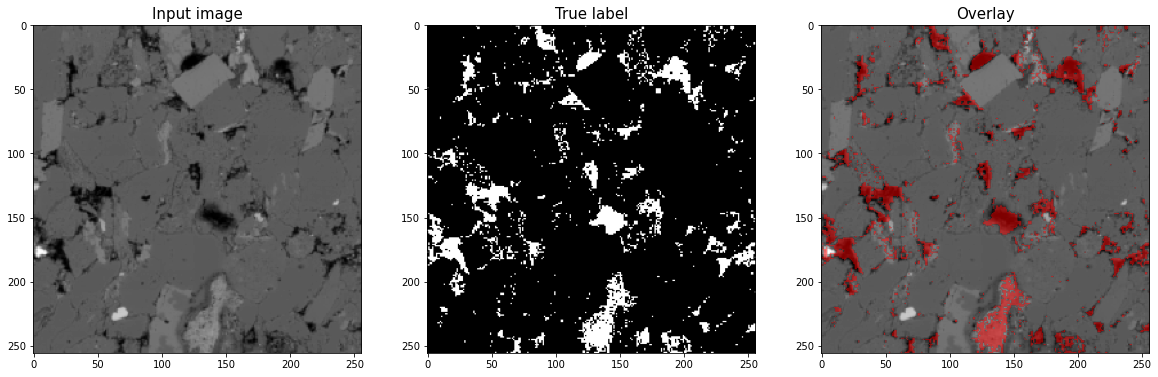

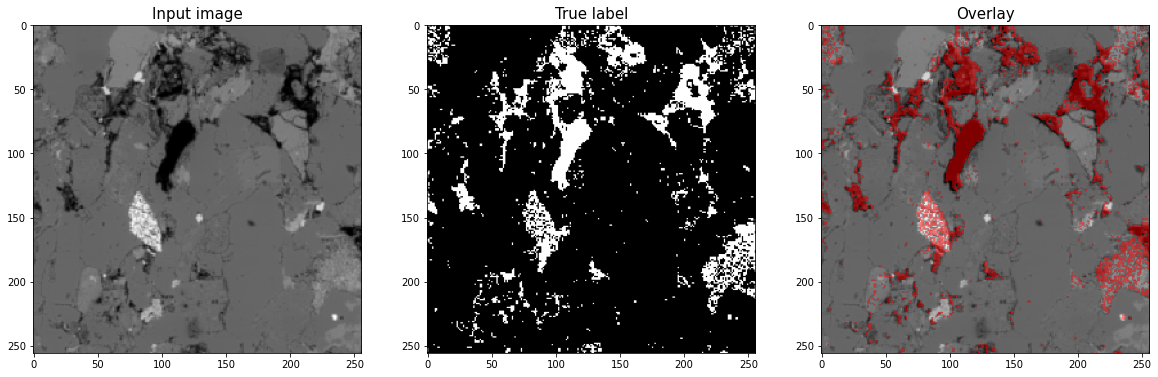

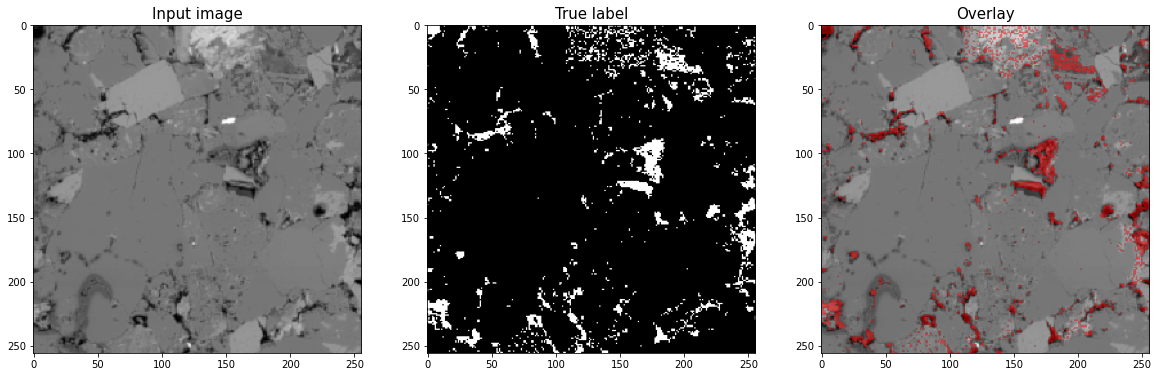

In [9]:
#plot images of 1st class (1st class binary mask)
plot_images(img_list.reshape(img_list.shape[0], 256,256), encoded_images, y_pred = None, num_to_plot = 3, class_num = 0)

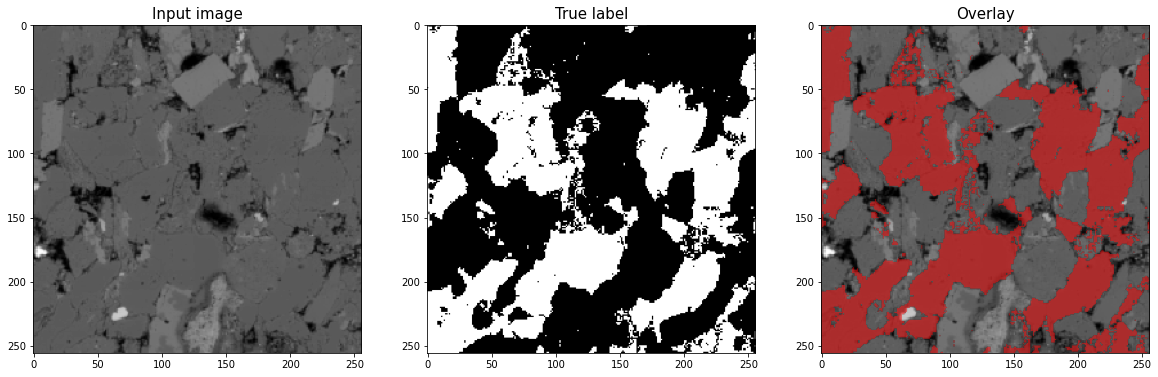

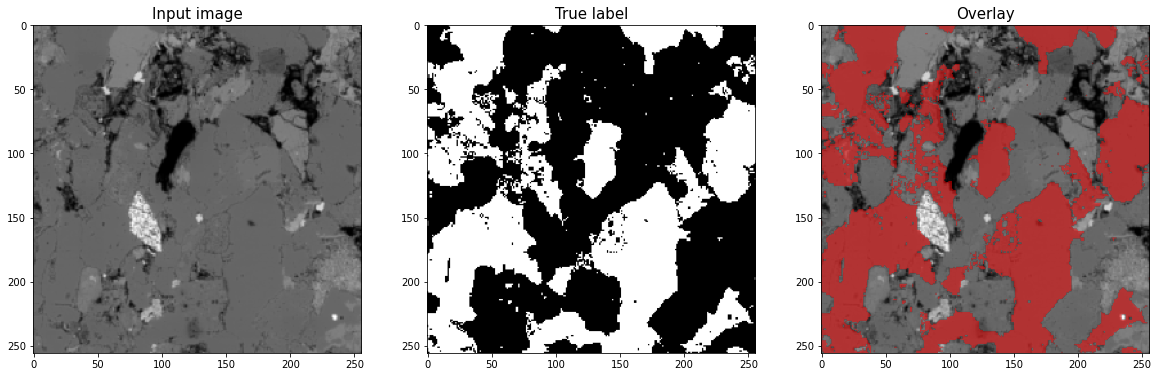

In [10]:
#plot images of 2nd class (2nd class binary mask)
plot_images(img_list.reshape(img_list.shape[0], 256,256), encoded_images, y_pred = None, num_to_plot = 3, class_num = 1)

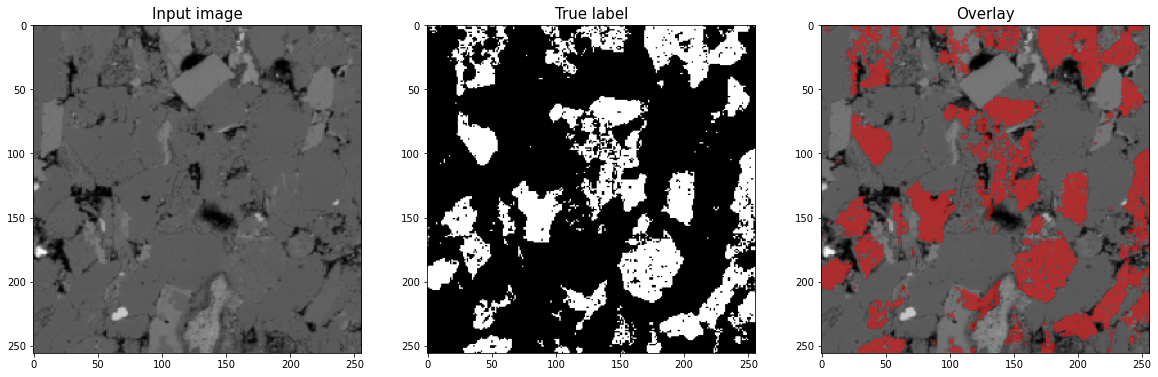

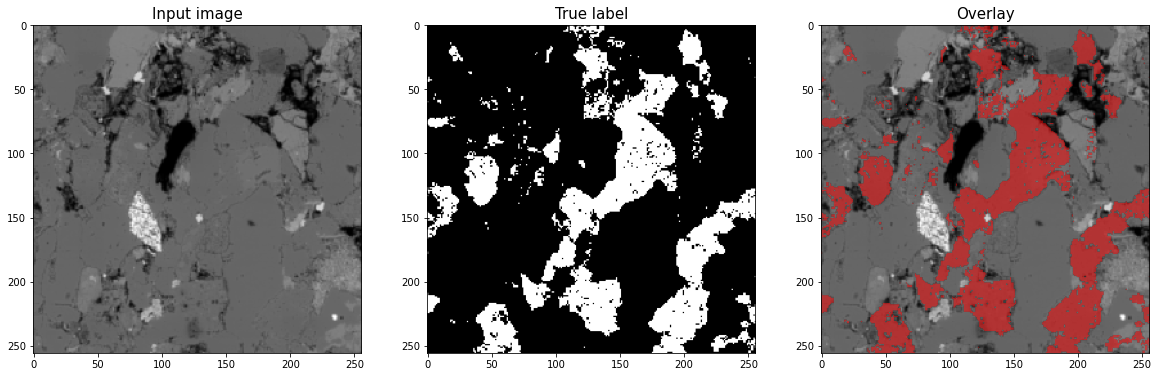

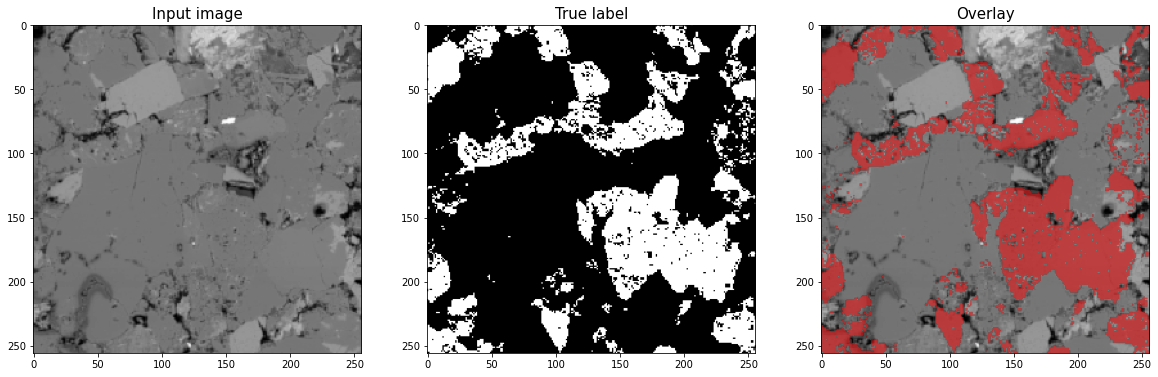

In [11]:
#plot images of 3rd class (3rd class binary mask)
plot_images(img_list.reshape(img_list.shape[0], 256,256), encoded_images, y_pred = None, num_to_plot = 3, class_num = 2)

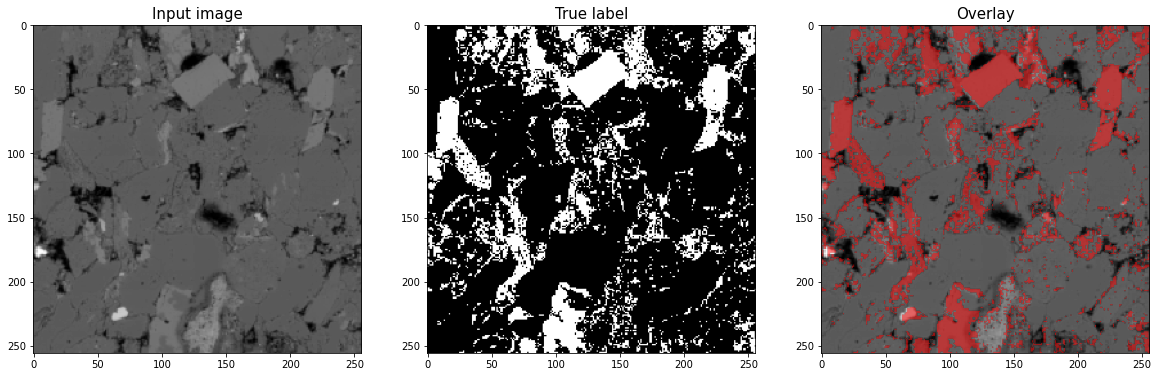

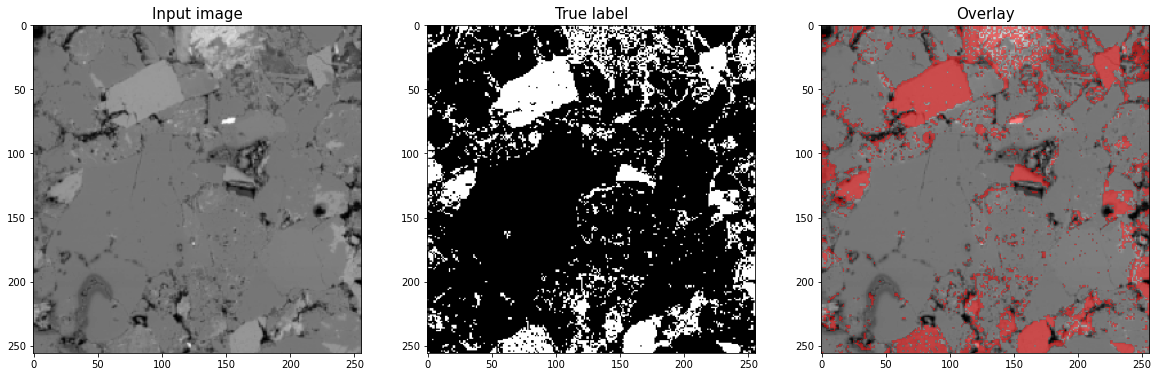

In [12]:
#plot images of 4th class (4th class binary mask)
plot_images(img_list.reshape(img_list.shape[0], 256,256), encoded_images, y_pred = None, num_to_plot = 3, class_num = 3)

# Example of traing using one of the datasets

In [0]:
import random
import re
import matplotlib.pyplot as plt
from pylab import *
import sys
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import *


from tensorflow.keras.applications.vgg16 import *
from tensorflow.keras.models import *


import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.compat.v1.layers import conv2d_transpose
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback, TensorBoard

### Unet and Linknet models

In [0]:
# import metrics
from lib.metrics import iou, iou_with_threshold

In [0]:
from sklearn.model_selection import train_test_split

input_img = Input(img_list.shape[1:], name='img')
X_train, X_val, y_train, y_val = train_test_split(np.asarray(img_list, dtype = float32), np.asarray(encoded_images, dtype = float32),
                                                  test_size=0.4, random_state = 0)

ids = [i for i in range(len(img_list))]
X_train_ids, X_val_ids, y_train_ids, y_val_ids = train_test_split(ids, ids,
                                                  test_size=0.4, random_state = 0)

In [0]:
from lib.utils import augment_data

batch_size = 15
steps_per_epoch = int(np.ceil(len(masks)/batch_size))
train_gen = augment_data(
    X_train, y_train, batch_size= batch_size,
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=50,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

train_generator = (pair for pair in train_gen)


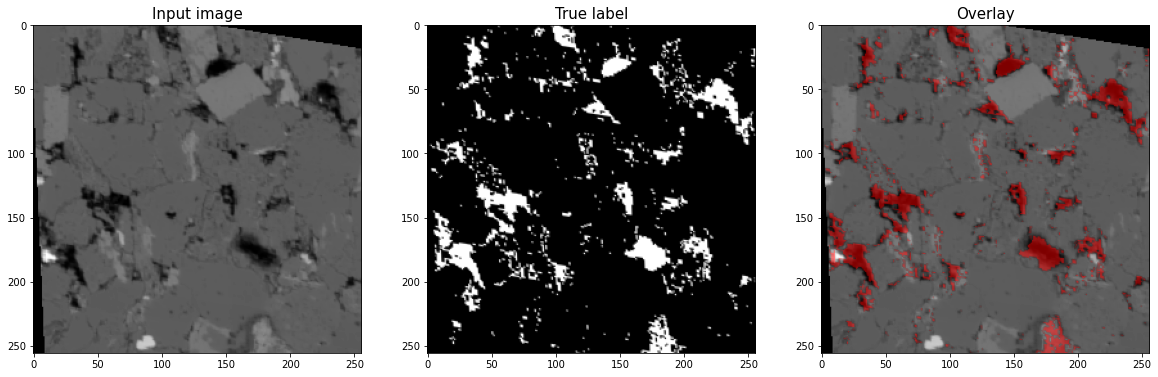

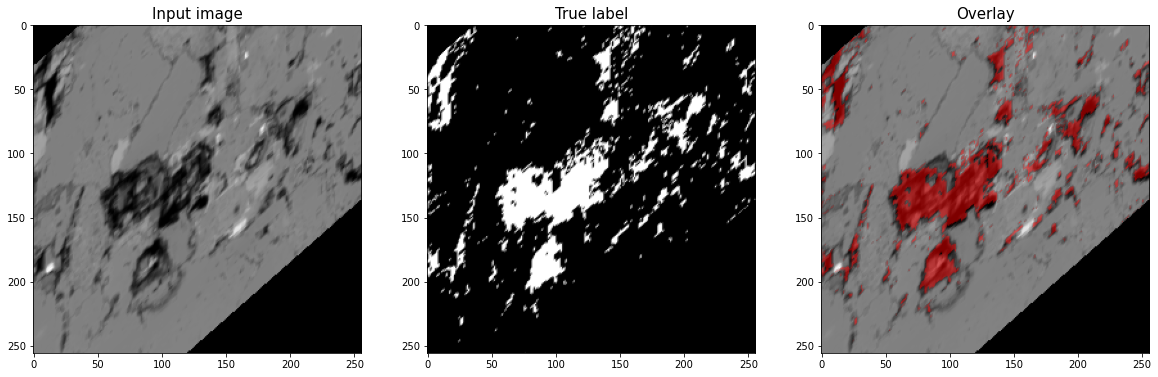

In [19]:
# plot examples of augmented data
x_aug, y_aug = next(train_generator)

plot_images(x_aug.reshape(x_aug.shape[0], x_aug.shape[1], x_aug.shape[2]),
            y_aug, y_pred = None, num_to_plot = 3, class_num = 0)


In [20]:
# library contaning segmentation models, wrote by one cool Skoltech guy
#https://github.com/qubvel/segmentation_models
!pip install segmentation_models

In [21]:
SM_FRAMEWORK=tf.keras
import segmentation_models as sm
sm.set_framework('tf.keras')
import tensorflow
tensorflow.keras.backend.set_image_data_format('channels_last')

Segmentation Models: using `keras` framework.


Using TensorFlow backend.


In [0]:
from lib.cosine_scheduler import CosineAnnealingScheduler, exp_schedule

In [0]:
#uncomment in case you want to launch tensorboard visualization
'''%load_ext tensorboard
%tensorboard --logdir logs/fit_segmentation'''

In [0]:
backbone = 'inceptionv3'
steps_per_epoch = int(np.ceil(len(X_train)/batch_size))

# define model
N = X_train.shape[-1]
model = sm.Unet( #select Unet or Linknet
    backbone, 
    classes=len(counts), activation='softmax',
    #encoder_weights='imagenet', #uncomment in case ypu want to use pre-trained weights
    #encoder_freeze=True,
    encoder_weights=None,
    input_shape=(None, None, N),
    decoder_use_batchnorm = True
)

class_weight=np.array([(1 / counts[i])*(total)/4.0 for i in range(len(counts))])

dice_loss = sm.losses.DiceLoss(class_weights=class_weight) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

model.compile(
    tf.keras.optimizers.Adam(lr=0.0003, amsgrad=False),
    loss= total_loss,
    metrics=[iou, iou_with_threshold, 'accuracy']
)

In [26]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 288         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

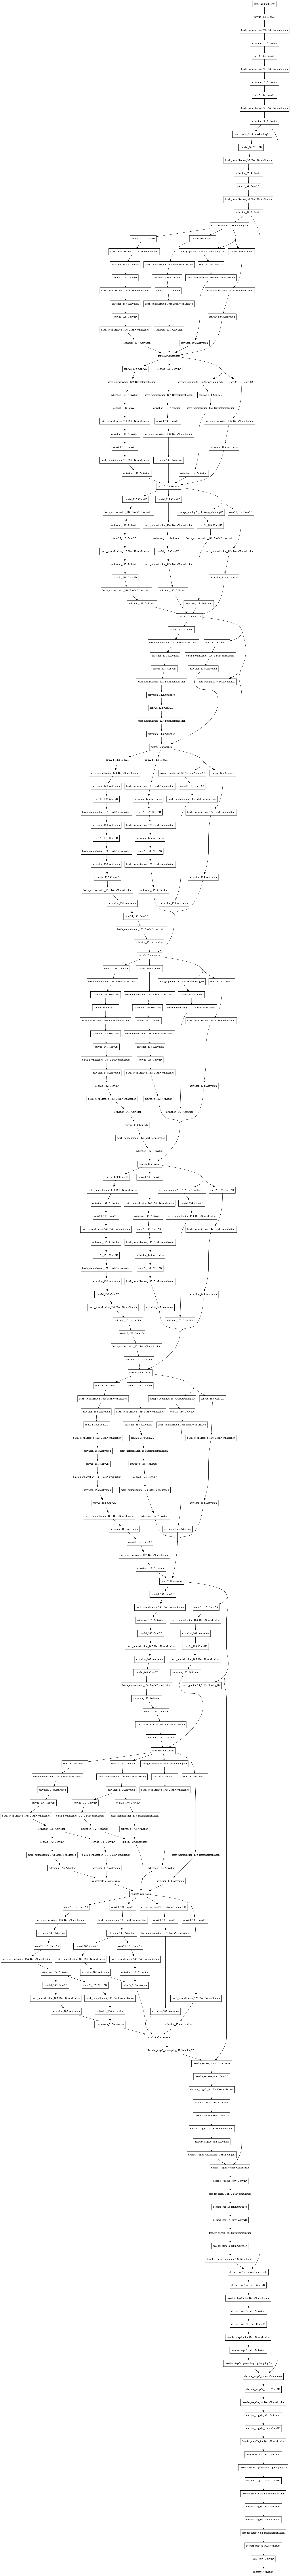

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model2.png')

In [0]:
%load_ext tensorboard
%tensorboard --logdir logs/fit_segmentation

In [0]:
#%reload_ext tensorboard
log_dir = "logs/fit_segmentation/"+'Unet_256_'+ backbone #define the dir to save the Tensorboard callbacks
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=5)
%tensorboard --logdir logs/fit_segmentation

### Loss and iou metrics for one of the models

![Loss for one of the models](https://github.com/ddvika/Sem_segmentation/blob/master/imgs/losses.png?raw=true)

![iou metrics for one of the models](https://github.com/ddvika/Sem_segmentation/blob/master/imgs/iou.png?raw=true)

In [0]:
model_filename = 'Unet_256_' + backbone + '.h5'
scheduler = CosineAnnealingScheduler(T_max=100, eta_max=1e-4, eta_min=1e-5)
#scheduler = tf.keras.callbacks.LearningRateScheduler(exp_schedule) # exponential scheduler
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    #verbose=1, 
    monitor='val_iou', 
    mode = 'max',
    save_best_only=True,
    period = 1)

history = model.fit(train_generator,epochs=80,
                    verbose = 1,
                              steps_per_epoch=steps_per_epoch,
                              validation_data = (X_val, y_val),
                              callbacks = [scheduler, callback_checkpoint, tensorboard_callback],
                              shuffle = 'True')

Epoch 1/80
119/119 [==============================] - 47s 391ms/step - loss: 0.3818 - iou: 0.4473 - iou_thresholded: 0.4633 - accuracy: 0.5953 - val_loss: 0.3910 - val_iou: 0.4684 - val_iou_thresholded: 0.4925 - val_accuracy: 0.6596 - lr: 7.0000e-05
Epoch 2/80
119/119 [==============================] - 44s 373ms/step - loss: 0.3806 - iou: 0.4470 - iou_thresholded: 0.4631 - accuracy: 0.5939 - val_loss: 0.3517 - val_iou: 0.5189 - val_iou_thresholded: 0.5397 - val_accuracy: 0.7002 - lr: 6.9985e-05
Epoch 3/80
119/119 [==============================] - 42s 350ms/step - loss: 0.3809 - iou: 0.4473 - iou_thresholded: 0.4633 - accuracy: 0.5937 - val_loss: 0.3564 - val_iou: 0.5145 - val_iou_thresholded: 0.5367 - val_accuracy: 0.6977 - lr: 6.9941e-05
Epoch 4/80
119/119 [==============================] - 44s 366ms/step - loss: 0.3813 - iou: 0.4465 - iou_thresholded: 0.4624 - accuracy: 0.5936 - val_loss: 0.3486 - val_iou: 0.5200 - val_iou_thresholded: 0.5426 - val_accuracy: 0.7029 - lr: 6.9867e-05


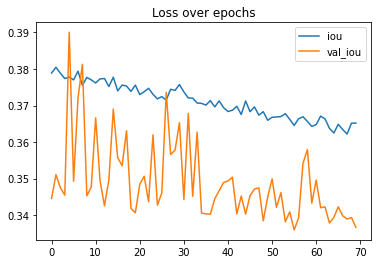

In [0]:
plt.plot(history.history['loss'][10:], label = 'iou')
plt.plot(history.history['val_loss'][10:], label = 'val_iou')
plt.title('Loss over epochs')
plt.legend()
plt.show()

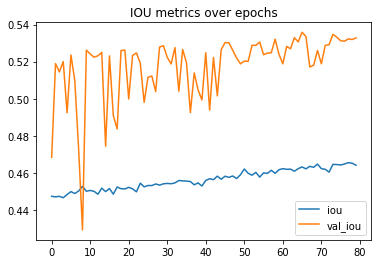

In [0]:
plt.plot(history.history['iou'], label = 'iou')
plt.plot(history.history['val_iou'], label = 'val_iou')
plt.title('IOU metrics over epochs')
plt.legend()
plt.show()

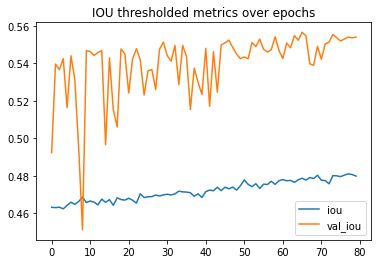

In [0]:
plt.plot(history.history['iou_thresholded'], label = 'iou')
plt.plot(history.history['val_iou_thresholded'], label = 'val_iou')
plt.title('IOU thresholded metrics over epochs')
plt.legend()
plt.show()

In [0]:
from tensorflow.keras.models import load_model
model.load_weights('Unet_256_' +backbone+'.h5') #segm_model_v0_1clas_recrop.h5

y_pred = model.predict(X_val)

In [0]:
for n in range(0,4):
  print(str(n) + ': \n')
  print('iou_final:', iou(y_val[:,:,:,n:n+1], y_pred[:,:,:, n], smooth=1.))
  print('iou_final thresholded:' + str(0.5), iou_thresholded(y_val[:,:,:,n:n+1], y_pred[:,:,:, n], threshold = 0.5))

0: 

iou_final: tf.Tensor(0.5860591, shape=(), dtype=float32)
iou_final thresholded:0.5 tf.Tensor(0.6024008, shape=(), dtype=float32)
1: 

iou_final: tf.Tensor(0.63359183, shape=(), dtype=float32)
iou_final thresholded:0.5 tf.Tensor(0.65609235, shape=(), dtype=float32)
2: 

iou_final: tf.Tensor(0.515806, shape=(), dtype=float32)
iou_final thresholded:0.5 tf.Tensor(0.53892493, shape=(), dtype=float32)
3: 

iou_final: tf.Tensor(0.42107657, shape=(), dtype=float32)
iou_final thresholded:0.5 tf.Tensor(0.4397306, shape=(), dtype=float32)


In [0]:
from lib.utils import plot__predicted_images

In [0]:
#plot predicted data
n = 0
plot__predicted_images(org_imgs=X_val, mask_imgs=y_val[:,:,:,n:n+1], pred_imgs=threshold_binarize(y_pred[:,:,:, n], threshold= 0.5), num_to_plot = 3, class_num = 0)

## Plot all the predicted classes together

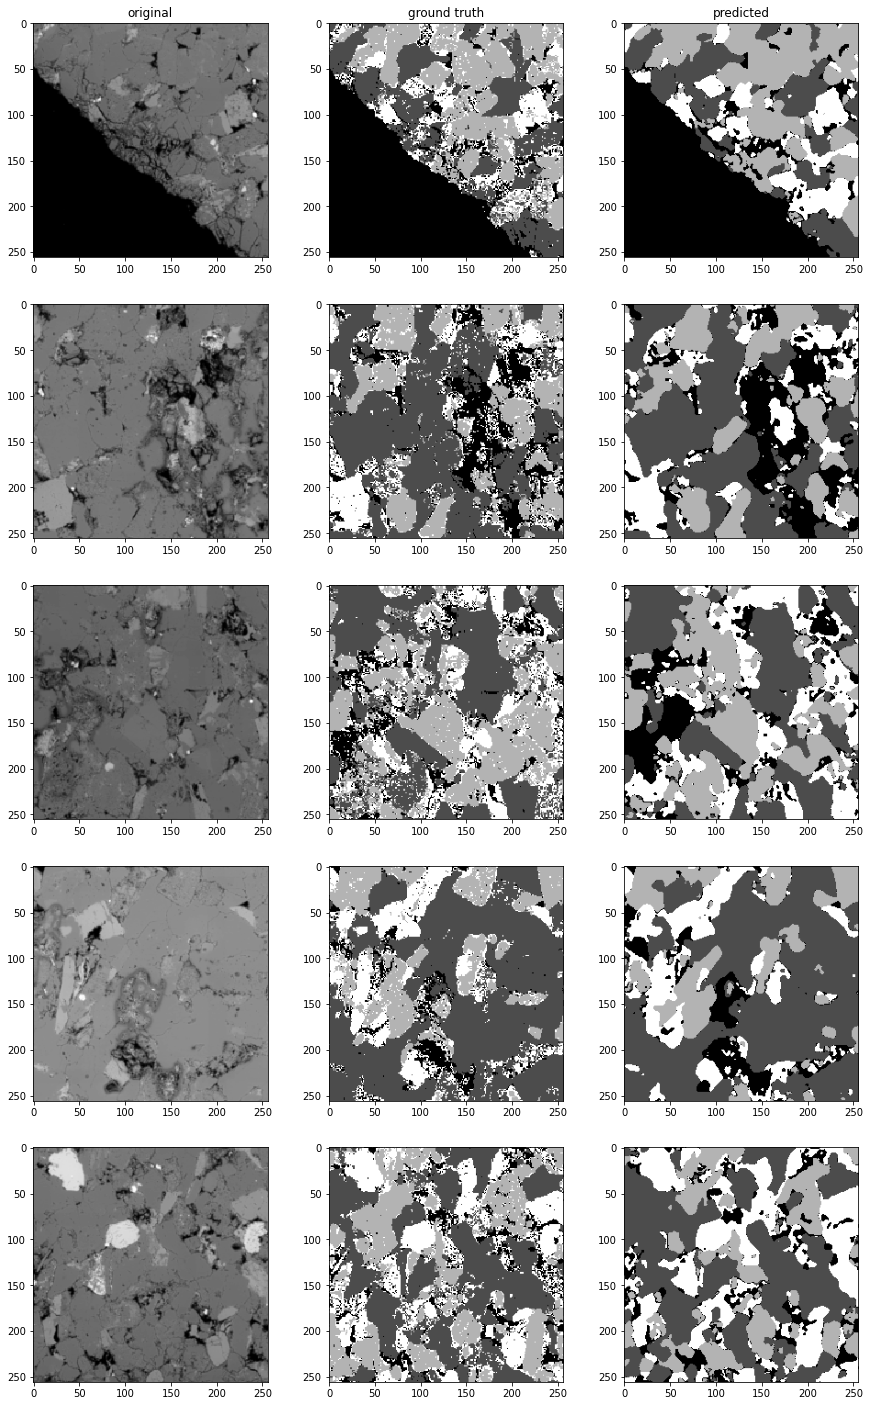

In [0]:
fig, axs = plt.subplots(5,3, figsize = (15,25))
axs[0, 0].set_title('original')
axs[0, 1].set_title('ground truth')
axs[0, 2].set_title('predicted')

for i in range(5):
  axs[i, 0].imshow(img_list[X_val_ids[i]].reshape(256, 256), 'gray')
  axs[i, 1].imshow(mask_list[X_val_ids[i]].reshape(256, 256), 'gray')
  pred_img = np.sum(np.array([colormap[j] * threshold_binarize(y_pred[i, :, :, j], threshold= 0.5).numpy() for j in range(len(colormap))]), axis = 0)
  axs[i, 2].imshow(pred_img, 'gray')
plt.show()

### define training for custom model, ResUnet and custom Unet models (you can find code in "lib" folder)

In [0]:
# import custom model
from lib.custom_model import get_custom_model

'''you can iport any of the models listed below'''

#from lib.custom_unet import custom_unet
#from lib.custom_segnet import custom_segnet
#from lib.custom_resunet import ResUnet

In [0]:
steps_per_epoch = int(np.ceil(len(X_train)/batch_size))

# define model
N = X_train.shape[-1]
model = get_custom_model(n_filters=16,
                         kernel_size = 3,
                         dropout=0.5,
                         kernel_initializer = 'he_normal',
                         activation = 'relu'
)

class_weight=np.array([(1 / counts[i])*(total)/4.0 for i in range(len(counts))])

dice_loss = sm.losses.DiceLoss(class_weights=class_weight) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

model.compile(
    tf.keras.optimizers.Adam(lr=0.0003, amsgrad=False),
    loss= total_loss,
    metrics=[iou, iou_thresholded, 'accuracy']
)

In [0]:
model_filename = '' #name of the model
scheduler = CosineAnnealingScheduler(T_max=100, eta_max=1e-4, eta_min=1e-5)
#scheduler = tf.keras.callbacks.LearningRateScheduler(exp_schedule) # exponential scheduler
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    #verbose=1, 
    monitor='val_iou', 
    mode = 'max',
    save_best_only=True,
    period = 1)

history = model.fit(train_generator,epochs=80,
                    verbose = 1,
                              steps_per_epoch=steps_per_epoch,
                              validation_data = (X_val, y_val),
                              callbacks = [scheduler, callback_checkpoint, tensorboard_callback],
                              shuffle = 'True')

#  Low Resolution 128x128 and 256x256 images
Number before dash (/) - is the iou for 128x128 images

Number after dash (/) - is the iou for 256x256 images


| Model+backbone \ iou_thersholded | 1(pores) | 2(quartz) | 3(albite) | 4(clay+accs) |
|:----------------------------------:|:----:|:----:|:----:|:----:|
| Custom model, 8 layers | 0.59/0.61 | 0.53/0.55 | 0.4/0.42 | 0.4/0.43 |
| Unet+inceptionv3, 159 layers | **0.63/0.65** | **0.58/0.64** | **0.45/0.52** | **0.44/0.47** |
| Unet+inceptionresnetv2, 572 layers | **0.63/0.65** | 0.56**/0.64** | 0.41**/0.52** | 0.43**/0.47** |
| UUnet+efficientb3, | 0.61 | 0.6 | **0.46** | **0.44** |
| Unet+efficientb4 | **0.63**/0.64 | **0.58**/0.61 | **0.45**/0.49 | **0.44**/0.45 |
| Linknet+efficientb3 | **0.63** | 0.57 | 0.43 | **0.44** |
| Linknet+inceptionv3 | /**0.65** | /**0.64** | /**0.52** | /**0.47** |
|ResUNet| /**0.65** | /0.62 | /0.49 | /**0.47** |
|Unet+Resnet18|0.62|0.55|0.41|042|
|Unet+VGG16|0.62 |0.57|0.43|0.43|
|Unet+VGG19|0.62|0.57|0.42|0.43|

#High Resolution (another high-reso dataset with the same images) 512x512 pictures(collab OOM) (tested only 200/1600)
| Model \ iou_thersholded | 1(pores) | 2(quartz) | 3(albite) | 4(clay+accs) | 5(background)|
|:----------------------------------:|:----:|:----:|:----:|:----:|:----:|
| ResUNet | 0.48 | 0.56 | 0.46 | 0.44 | 0.99 |
|Unet+Resnet18| 0.51 | 0.62 | 0.48 | 0.46 | 0.999 |
|Unet+inceptionresnetv2|0.51 |0.62 | 0.5 | 0.47| 0.999|
|Unet+inceptionv3|0.51|0.61|0.48|0.46|0.999|
|Unet+efficientnetb4|0.51|0.65|0.53|0.47|0.999| 